# Мастерская 2

**Описние задачи**\
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

**Цель**\
Предсказать вероятность покупки в течение 90 дней

**Задачи**
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

## Изучение данных

In [4]:
!pip install phik -q

In [5]:
# Загрузка библиотек и модулей
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import phik

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [6]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

### История покупок

In [8]:
df_purch = pd.read_csv('apparel-purchases.csv')
df_purch.head(5)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [9]:
df_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


Сразу заменим типы данных в столбце date.

In [11]:
df_purch['date'] = pd.to_datetime(df_purch['date'])

In [12]:
df_purch.describe()

,client_id,quantity,price,date
count,2.022080e+05,202208.000000,202208.000000,202208
mean,1.515916e+18,1.006483,1193.301516,2023-03-17 02:49:35.739832064
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00
25%,1.515916e+18,1.000000,352.000000,2022-11-12 00:00:00
50%,1.515916e+18,1.000000,987.000000,2023-04-12 00:00:00
75%,1.515916e+18,1.000000,1699.000000,2023-07-03 00:00:00
max,1.515916e+18,30.000000,85499.000000,2024-02-16 00:00:00
std,1.459514e+08,0.184384,1342.252664,NaN


In [13]:
df_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


### История рекламных рассылок

In [15]:
df_mes = pd.read_csv('apparel-messages.csv')
df_mes.head(3)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


In [16]:
df_mes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


Исправим тип данных на дату в соответствующих столбцах.

In [18]:
df_mes['date'] = pd.to_datetime(df_mes['date'])
df_mes['created_at'] = pd.to_datetime(df_mes['created_at'])

In [19]:
df_mes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [20]:
df_mes.describe()

,bulk_campaign_id,client_id,date,created_at
count,1.273980e+07,1.273980e+07,12739798,12739798
mean,1.160459e+04,1.515916e+18,2023-06-05 02:46:08.357990400,2023-06-05 13:58:11.168689408
min,5.480000e+02,1.515916e+18,2022-05-19 00:00:00,2022-05-19 00:14:20
25%,8.746000e+03,1.515916e+18,2022-12-19 00:00:00,2022-12-19 12:46:30
50%,1.351600e+04,1.515916e+18,2023-07-20 00:00:00,2023-07-20 17:21:54
75%,1.415800e+04,1.515916e+18,2023-11-21 00:00:00,2023-11-21 18:13:05
max,1.465700e+04,1.515916e+18,2024-02-15 00:00:00,2024-02-15 23:58:40
std,3.259211e+03,3.265518e+08,NaN,NaN


### Статус покупок (целевой признак)

In [22]:
df_target = pd.read_csv('apparel-target_binary.csv')
df_target.head(3)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0


In [23]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


## Предобработка данных

### Обработка дубликатов

In [26]:
df_purch.duplicated().sum()

73020

In [27]:
df_purch.duplicated().sum()/df_purch.shape[0]

0.36111330906789046

36 % дубликатов - очень большое количество. Целесообразно будет предположить, что клиенты делали повторные покупки в течение одного дня. Пока очтавим дубликаты.

In [29]:
df_purch.duplicated().sum()

73020

In [30]:
df_mes.duplicated().sum()/df_mes.shape[0]

0.0038156020998135133

0,3 % дубликатов скорее всего связаны с дублированием рассылки. Удалим дубликаты.

In [32]:
df_mes = df_mes.drop_duplicates()

In [33]:
df_mes.duplicated().sum()

0

In [34]:
df_target.duplicated().sum()

0

In [35]:
df_target.duplicated().sum()

0

In [36]:
df_target.duplicated().sum()

0

In [37]:
df_purch['category_ids'] = df_purch['category_ids'].apply(ast.literal_eval)

In [38]:
for pos in range(0,5):
    df_purch['category_' + str(pos)] =\
    df_purch.apply(lambda x: x['category_ids'][pos] if (~(x['category_ids'] is np.nan) & (len(x['category_ids']) > pos)) else 0, axis=1)
    df_purch['category_' + str(pos)] = df_purch['category_' + str(pos)].fillna(0)
    df_purch['category_' + str(pos)] = df_purch['category_' + str(pos)].astype(int)

In [39]:
df_purch.head()

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,0


## Исследовательский анализ данных

### Общий анализ

In [42]:
def charts(df, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15, 5))

    # гистограмма с графиком плотности 
    sns.histplot(df[col], bins=30, kde=True, ax=ax1)
    ax1.ticklabel_format(axis='x')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Количество')
    ax1.set_title(f'Гистограмма для {col}', 
                    color='black', fontweight ='bold')
    ax1.grid(linestyle='--')

    # диаграмма размаха
    sns.boxplot(y=df[col], ax=ax2)
    ax2.ticklabel_format(axis='y')
    ax2.set_xlabel(col)
    ax2.set_ylabel('Значение')
    ax2.set_title(f'Диаграмма размаха для {col}', 
                    color='black', fontweight ='bold')
    ax2.grid(linestyle='--')

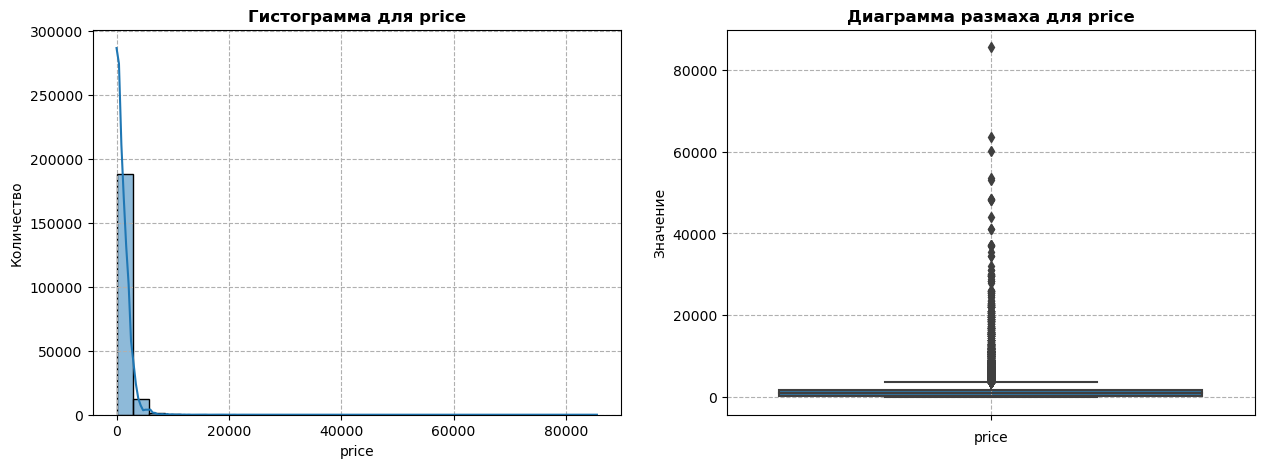

In [43]:
charts(df_purch, 'price')

In [44]:
df_purch = df_purch[df_purch['price'] <= 40000]

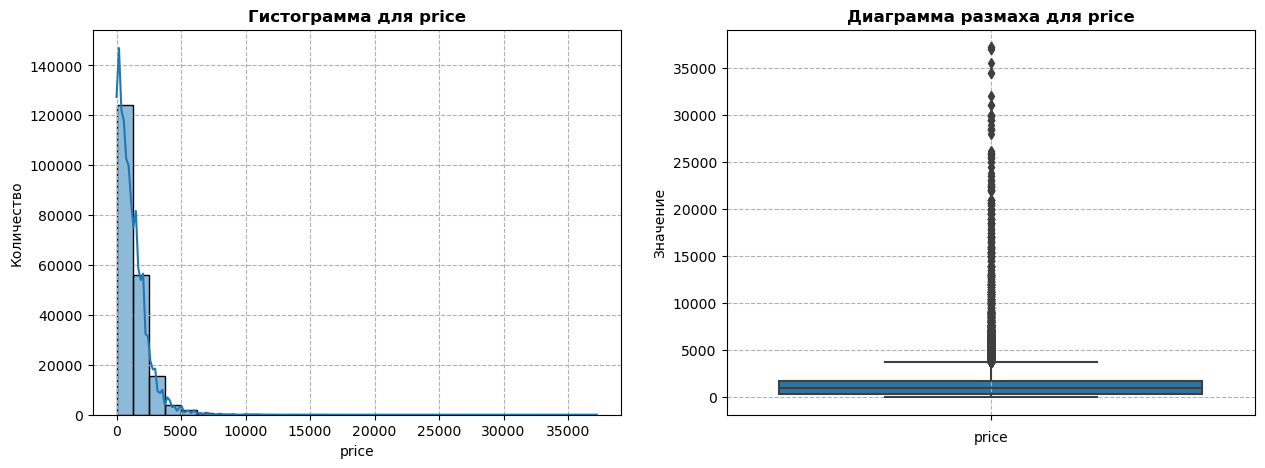

In [45]:
charts(df_purch, 'price')

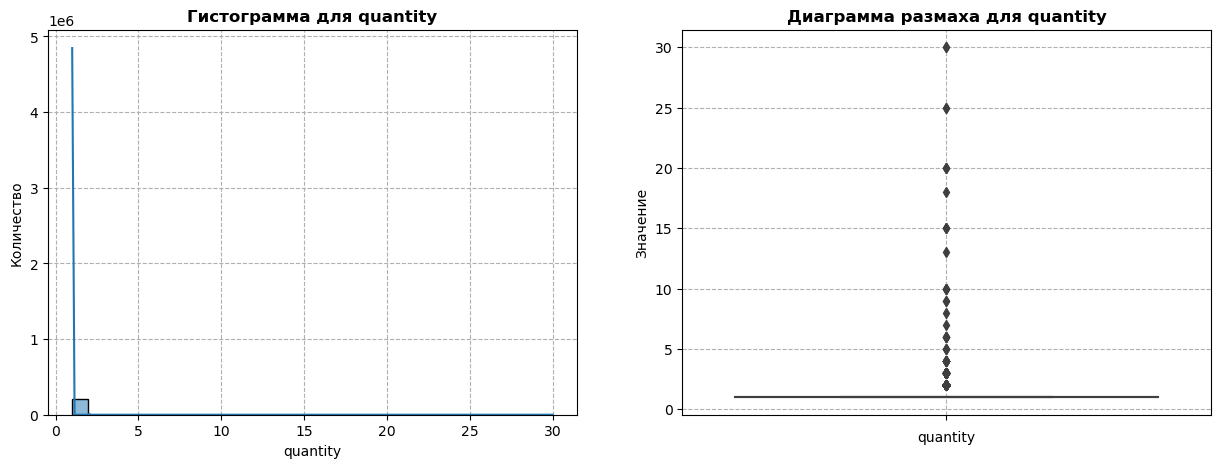

In [46]:
charts(df_purch, 'quantity')

In [47]:
df_purch = df_purch[df_purch['quantity'] <= 10]

In [48]:
df_mes['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

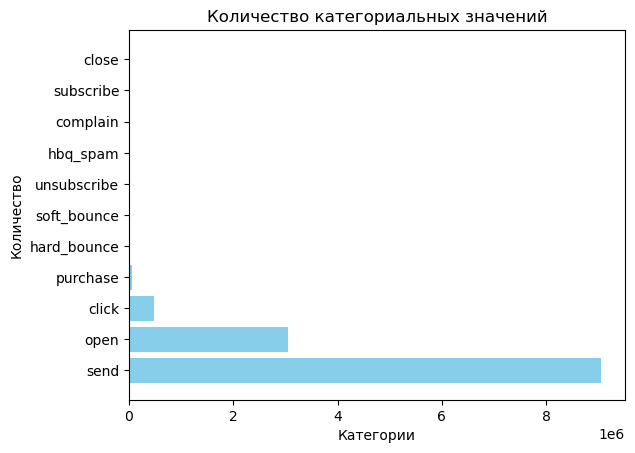

In [49]:
category_counts = df_mes['event'].value_counts()
plt.barh(category_counts.index, category_counts.values, color='skyblue')
plt.title('Количество категориальных значений')
plt.xlabel('Категории')
plt.ylabel('Количество')
plt.show()

In [50]:
df_mes['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

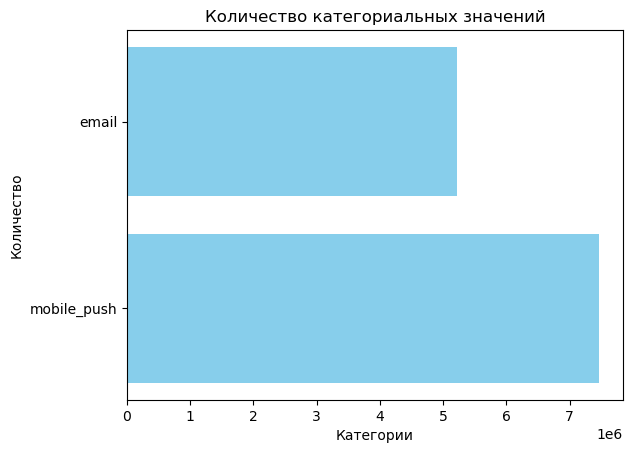

In [51]:
category_counts = df_mes['channel'].value_counts()
plt.barh(category_counts.index, category_counts.values, color='skyblue')
plt.title('Количество категориальных значений')
plt.xlabel('Категории')
plt.ylabel('Количество')
plt.show()

Выполнено исследование состава признаков. Исключены выбросы по цене и количеству покупок.

### Добавление признака

In [54]:
#сумма за покупку в данной категории
df_purch['revenue'] = df_purch['quantity'] * df_purch['price']

In [55]:
df_purch.head()

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4,revenue
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,1999.0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,2499.0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,0,6499.0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,0,4999.0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,0,4999.0


### Проверка вхождения дублирующихся признаков

#### client_id

In [58]:
df_purch['client_id'].nunique()

49842

In [59]:
df_purch['client_id'].nunique()

49842

Количество уникальных client_id в таблицах apparel_messages и apparel_messages не сходится. Нужно проверить все ли уникальные значения признака client_id из одной таблицы присутствуют в другой.

In [61]:
df_mes[df_mes['client_id'].isin(df_purch['client_id'].unique())]['client_id'].nunique()

41976

Часть данных из таблицы apparel_purchases отсутствует в таблице apparel_messages. Выведем несколько строк и изучим их.

В начале часто message_id (первые 19 знаков) указан id клиента. Однако это не распространяется на всех клиентов. В некоторых случаях в таблице apparel_purchases первые 19 знаков и client_id отличаются.

In [64]:
df_purch[df_purch['client_id'].isin(df_target['client_id'].unique())]['client_id'].nunique()

49842

- все client_id из apparel_target_binary есть в apparel_purchases,

In [66]:
df_purch = df_purch[df_purch['client_id'].isin(df_target['client_id'].unique())]
df_purch['client_id'].nunique()

49842

#### message_id

Проверим все ли message_id из apparel_messages есть в apparel_purchases.

In [69]:
df_mes['message_id'].nunique()

9061667

In [70]:
df_purch[df_purch['message_id'].isin(df_mes['message_id'].unique())]['message_id'].nunique()

49806

In [71]:
df_purch[~df_purch['message_id'].isin(df_mes['message_id'].unique())].head()

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4,revenue
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,1999.0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,2499.0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,0,6499.0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,0,4999.0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,0,4999.0


In [72]:
df_purch[~df_purch['message_id'].isin(df_mes['message_id'].unique())]['message_id'].nunique()

394

Так как не все message_id из apparel_messages есть в apparel_purchase, то при объединении таблиц поставим заглушки (нули), которые позволят избежать шума в данных.

## Объединение и преобразование таблиц

### Преобразование apparel_messages

In [76]:
df_mes_ch = pd.pivot_table(df_mes,
                        index = 'message_id',
                        columns = 'channel',
                        values = 'client_id',
                        aggfunc = 'count').reset_index().fillna(0)

In [77]:
df_mes_ev = pd.pivot_table(df_mes,
                           index = 'message_id',
                           columns = 'event',
                           values = 'client_id',
                           aggfunc = 'count').reset_index().fillna(0)

In [78]:
df_mes_2 = pd.merge(df_mes_ch, 
                    df_mes_ev, 
                    on='message_id', 
                    how='inner')
df_mes_2.head()

,message_id,email,mobile_push,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902-10022-63e5ededd911f,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1515915625468060902-10218-63ef56ed94656,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1515915625468060902-10289-63f35a8a9ff35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1515915625468060902-10373-63f5cbba42484,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1515915625468060902-10507-63ff04f701e74,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [79]:
df_mes_3 = pd.merge(df_mes_2, 
                    df_mes, 
                    on='message_id', 
                    how='left').drop(['client_id', 'event', 'channel', 'date', 'created_at'], axis=1)
df_mes_3.head()

,message_id,email,mobile_push,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,bulk_campaign_id
0,1515915625468060902-10022-63e5ededd911f,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10022
1,1515915625468060902-10218-63ef56ed94656,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10218
2,1515915625468060902-10289-63f35a8a9ff35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10289
3,1515915625468060902-10373-63f5cbba42484,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10373
4,1515915625468060902-10507-63ff04f701e74,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10507


### Объединение apparel_purchases и apparel_messages_3

In [81]:
df = pd.merge(df_purch, 
              df_mes_3, 
              on='message_id', 
              how='left').fillna(0)
df.head()

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,...,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,bulk_campaign_id
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
df['client_id'].nunique()

49842

### Преобразование df

In [84]:
df_qr_mes = df.groupby('client_id')[['quantity', 'revenue','email', 'mobile_push', 'click', 'close', 'complain',
       'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce',
       'subscribe', 'unsubscribe']].sum().reset_index()
df_qr_mes.head(3)

,client_id,quantity,revenue,email,mobile_push,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,77,76923.0,847.0,0.0,308.0,0.0,0.0,0.0,0.0,77.0,385.0,77.0,0.0,0.0,0.0
1,1515915625468061003,28,64940.0,112.0,0.0,28.0,0.0,0.0,0.0,0.0,28.0,28.0,28.0,0.0,0.0,0.0
2,1515915625468061099,1,299.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
df_сats = df.groupby('client_id')[['category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'bulk_campaign_id']].apply(pd.DataFrame.mode).reset_index()
df_сats.head(3)

,client_id,level_1,category_0,category_1,category_2,category_3,category_4,bulk_campaign_id
0,1515915625468060902,0,4.0,28.0,176.0,420.0,0.0,4617.0
1,1515915625468060902,1,NaN,NaN,260.0,458.0,NaN,NaN
2,1515915625468061003,0,4.0,28.0,249.0,615.0,0.0,9148.0


In [86]:
df_сats = df_сats[df_сats['level_1'] == 0].drop('level_1', axis=1).fillna(0)

In [87]:
df_сats.shape

(49842, 7)

In [88]:
df_сats.head()

,client_id,category_0,category_1,category_2,category_3,category_4,bulk_campaign_id
0,1515915625468060902,4.0,28.0,176.0,420.0,0.0,4617.0
2,1515915625468061003,4.0,28.0,249.0,615.0,0.0,9148.0
3,1515915625468061099,4.0,28.0,290.0,424.0,0.0,0.0
4,1515915625468061100,4.0,27.0,1828.0,5717.0,0.0,14623.0
5,1515915625468061170,4.0,28.0,260.0,420.0,0.0,11208.0


In [89]:
df_pr = df.groupby('client_id')['price'].mean().reset_index()
df_pr.head(3)

,client_id,price
0,1515915625468060902,999.000000
1,1515915625468061003,2319.285714
2,1515915625468061099,299.000000


In [90]:
df_pr.shape

(49842, 2)

In [91]:
df_date_mes = df.groupby('client_id')['message_id'].count().reset_index()
df_date_mes.head(3)

,client_id,message_id
0,1515915625468060902,77
1,1515915625468061003,28
2,1515915625468061099,1


In [92]:
df_date_dif = pd.merge(df.groupby('client_id')['date'].min().reset_index(), 
                       df.groupby('client_id')['date'].max().reset_index(), 
                       on='client_id', 
                       how='left')
df_date_dif ['date_dif'] = (pd.to_datetime(df_date_dif ['date_y']) - pd.to_datetime(df_date_dif ['date_x'])).dt.days
df_date_dif.head()

,client_id,date_x,date_y,date_dif
0,1515915625468060902,2022-05-27,2022-05-27,0
1,1515915625468061003,2023-01-04,2023-01-04,0
2,1515915625468061099,2022-05-17,2022-05-17,0
3,1515915625468061100,2024-02-10,2024-02-10,0
4,1515915625468061170,2023-03-26,2023-06-17,83


In [93]:
df_date_dif = df_date_dif.drop(['date_x', 'date_y'], axis=1)
df_date_dif.head()

,client_id,date_dif
0,1515915625468060902,0
1,1515915625468061003,0
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,83


In [94]:
df = pd.merge(df_qr_mes, df_сats, on='client_id', how='left')
df = pd.merge(df, df_pr, on='client_id', how='left')
df = pd.merge(df, df_date_mes, on='client_id', how='left')
df = pd.merge(df, df_date_dif, on='client_id', how='left')
df.head()

,client_id,quantity,revenue,email,mobile_push,click,close,complain,hard_bounce,hbq_spam,...,unsubscribe,category_0,category_1,category_2,category_3,category_4,bulk_campaign_id,price,message_id,date_dif
0,1515915625468060902,77,76923.0,847.0,0.0,308.0,0.0,0.0,0.0,0.0,...,0.0,4.0,28.0,176.0,420.0,0.0,4617.0,999.000000,77,0
1,1515915625468061003,28,64940.0,112.0,0.0,28.0,0.0,0.0,0.0,0.0,...,0.0,4.0,28.0,249.0,615.0,0.0,9148.0,2319.285714,28,0
2,1515915625468061099,1,299.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,28.0,290.0,424.0,0.0,0.0,299.000000,1,0
3,1515915625468061100,8,8392.0,0.0,32.0,8.0,0.0,0.0,0.0,0.0,...,0.0,4.0,27.0,1828.0,5717.0,0.0,14623.0,1049.000000,8,0
4,1515915625468061170,85,147643.0,415.0,0.0,141.0,0.0,0.0,0.0,0.0,...,0.0,4.0,28.0,260.0,420.0,0.0,11208.0,1736.976471,85,83


In [95]:
df.shape

(49842, 25)

## Корреляция

D:\Anaconda\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable close for analysis 1. Dropping this column
  warnings.warn(
D:\Anaconda\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable hbq_spam for analysis 1. Dropping this column
  warnings.warn(
D:\Anaconda\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable soft_bounce for analysis 1. Dropping this column
  warnings.warn(


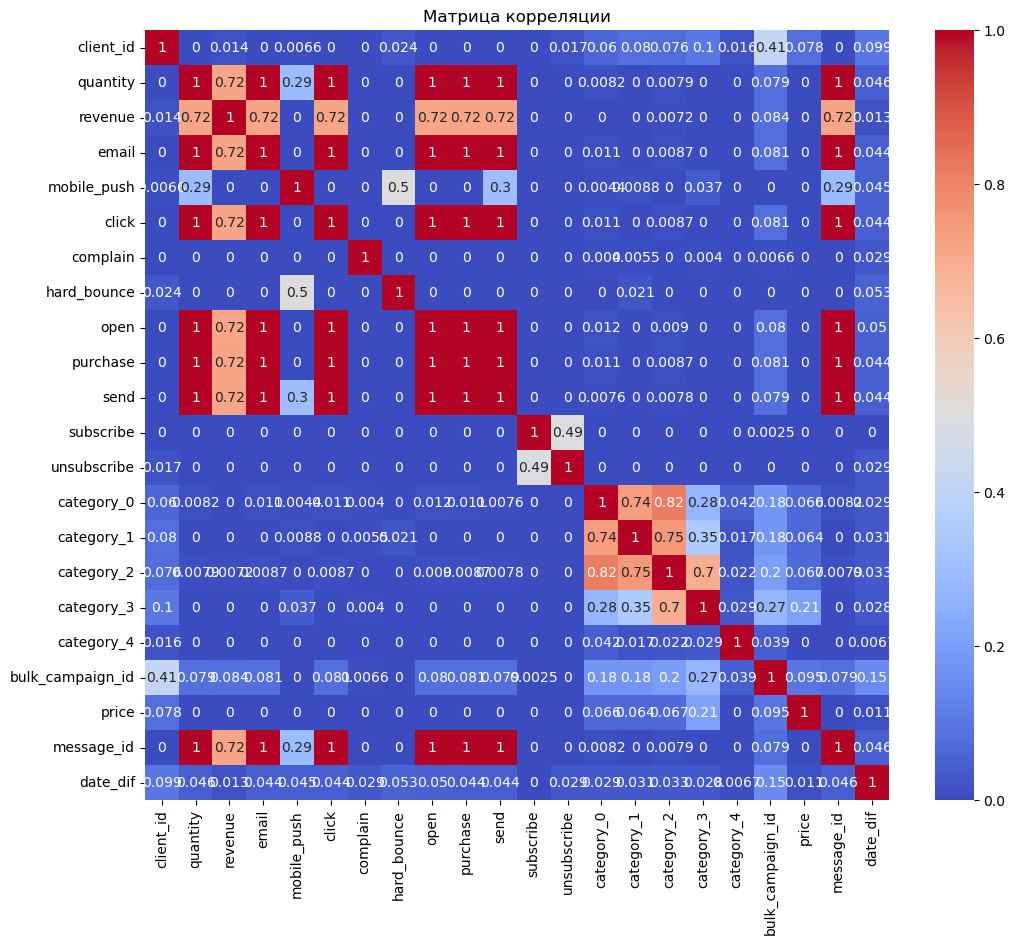

In [97]:
corr_matrix = df.phik_matrix(verbose= False)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show();

## Подготовка и обучение модели

In [99]:
df_target = df_target[df_target['client_id'].isin(df['client_id'].unique())]
df_target.shape

(49842, 2)

In [100]:
df.set_index('client_id', inplace=True)

In [101]:
df.index.name = None

In [102]:
df.head()

,quantity,revenue,email,mobile_push,click,close,complain,hard_bounce,hbq_spam,open,...,unsubscribe,category_0,category_1,category_2,category_3,category_4,bulk_campaign_id,price,message_id,date_dif
1515915625468060902,77,76923.0,847.0,0.0,308.0,0.0,0.0,0.0,0.0,77.0,...,0.0,4.0,28.0,176.0,420.0,0.0,4617.0,999.000000,77,0
1515915625468061003,28,64940.0,112.0,0.0,28.0,0.0,0.0,0.0,0.0,28.0,...,0.0,4.0,28.0,249.0,615.0,0.0,9148.0,2319.285714,28,0
1515915625468061099,1,299.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,28.0,290.0,424.0,0.0,0.0,299.000000,1,0
1515915625468061100,8,8392.0,0.0,32.0,8.0,0.0,0.0,0.0,0.0,8.0,...,0.0,4.0,27.0,1828.0,5717.0,0.0,14623.0,1049.000000,8,0
1515915625468061170,85,147643.0,415.0,0.0,141.0,0.0,0.0,0.0,0.0,104.0,...,0.0,4.0,28.0,260.0,420.0,0.0,11208.0,1736.976471,85,83


In [103]:
df_target.set_index('client_id', inplace=True)

In [104]:
df_target.index.name = None

In [105]:
df_target.head()

,target
1515915625468060902,0
1515915625468061003,1
1515915625468061099,0
1515915625468061100,0
1515915625468061170,0


In [106]:
X = df
y = df_target

In [107]:
cat_cols = ['category_0', 'category_1','category_2', 'category_3', 'category_4', 'bulk_campaign_id']

In [108]:
num_cols = ['quantity', 'revenue', 'email', 'mobile_push', 'click', 'close',
       'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send',
       'soft_bounce', 'subscribe', 'unsubscribe', 'price', 'message_id', 'date_dif']

In [109]:
X[cat_cols] = X[cat_cols].astype(int)

In [110]:
features_train, features_test, target_train, target_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [111]:
cbc_model = CatBoostClassifier(random_state=RANDOM_STATE, auto_class_weights='Balanced', iterations=200)

In [112]:
cbc_parameters = {
    'learning_rate': np.array([0.1, 0.5]),
    'depth': np.array([3, 7]),
    'l2_leaf_reg': np.array([3, 7])
}

In [113]:
cbc_grid = GridSearchCV(cbc_model, cbc_parameters, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')

cbc_grid.fit(features_train, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0:	learn: 0.6815800	total: 142ms	remaining: 28.3s
1:	learn: 0.6735644	total: 153ms	remaining: 15.2s
2:	learn: 0.6650342	total: 165ms	remaining: 10.8s
3:	learn: 0.6603666	total: 176ms	remaining: 8.6s
4:	learn: 0.6540084	total: 187ms	remaining: 7.31s
5:	learn: 0.6512346	total: 198ms	remaining: 6.39s
6:	learn: 0.6486467	total: 210ms	remaining: 5.79s
7:	learn: 0.6442084	total: 221ms	remaining: 5.31s
8:	learn: 0.6422257	total: 232ms	remaining: 4.92s
9:	learn: 0.6387054	total: 243ms	remaining: 4.63s
10:	learn: 0.6370294	total: 254ms	remaining: 4.36s
11:	learn: 0.6350628	total: 264ms	remaining: 4.14s
12:	learn: 0.6336783	total: 276ms	remaining: 3.97s
13:	learn: 0.6323084	total: 288ms	remaining: 3.83s
14:	learn: 0.6314798	total: 298ms	remaining: 3.68s
15:	learn: 0.6299808	total: 309ms	remaining: 3.56s
16:	learn: 0.6289166	total: 321ms	remaining: 3.45s
17:	learn: 0.6284022	total: 331ms	remaining: 3.34s
18:	learn: 0.6272485	total: 341ms

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000027964E7ACD0>,
             n_jobs=-1,
             param_grid={'depth': array([3, 7]), 'l2_leaf_reg': array([3, 7]),
                         'learning_rate': array([0.1, 0.5])},
             scoring='roc_auc', verbose=1)

In [114]:
cbc_results = cbc_grid.cv_results_
cbc_best_index = cbc_grid.best_index_

cbc_fit_time = cbc_results['mean_fit_time'][cbc_best_index]
cbc_score_time = cbc_results['mean_score_time'][cbc_best_index]
cbc_ROC_AUC = cbc_results['mean_test_score'][cbc_best_index]

print(f"Fit time: {cbc_fit_time}, Predict time: {cbc_score_time}, Best ROC-AUC: {cbc_ROC_AUC}")

Fit time: 13.427825546264648, Predict time: 0.24832758903503419, Best ROC-AUC: 0.6878068125309208


## Тестирование модели

In [116]:
probabilities = cbc_grid.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
print(f'ROC-AUC при тестировании:{roc_auc_score(target_test, probabilities_one)}')

ROC-AUC при тестировании:0.6872070304311003


## Вывод по проекту

Загружены данные об истории покупателей, истории рекламных рассылок и целевого признака.
Выполнена предобработка данных: установлены соответствующие типы данных, удалены дубликаты, значение категорий разбито на 4 отдельных столбца
В результате анализа датасетов были добавлены следующие признаки:

- количество купленного товара в разрезе категорий
- сумма выручки от одного клиента
- средня сумма покупки клиента
- разница между первой и последней датой покупки
- число событий по рекламным сообщениям по каждому клитенту
- число рекламных сообщений в разрезе видов
- наиболее часто покупаемые категории товара
- наиболее часто встречающийся идентификатор рассылки 

Выполнено обучение модели CatBoostСlassifier c GridSearchCV. Метрика ROC-AUC при тестировании - 0.69.

In [209]:
import pkg_resources

for dist in pkg_resources.working_set:
    print(dist.project_name, dist.version)

Automat 20.2.0
Babel 2.11.0
Bottleneck 1.3.5
Flask 2.2.2
HeapDict 1.0.1
Jinja2 3.1.2
Mako 1.3.5
Markdown 3.4.1
MarkupSafe 2.1.1
Protego 0.1.16
PyDispatcher 2.0.5
PyJWT 2.4.0
PyNaCl 1.5.0
PyQt5 5.15.10
PyQt5-sip 12.13.0
PyQtWebEngine 5.15.6
PySocks 1.7.1
PyWavelets 1.4.1
PyYAML 6.0
Pygments 2.15.1
QDarkStyle 3.0.2
QtAwesome 1.2.2
QtPy 2.2.0
Rtree 1.0.1
SQLAlchemy 1.4.39
Scrapy 2.8.0
Send2Trash 1.8.2
Sphinx 5.0.2
TBB 0.2
Twisted 22.10.0
Unidecode 1.2.0
Werkzeug 2.2.3
aext-assistant 4.0.15
aext-assistant-server 4.0.15
aext-core 4.0.15
aext-core-server 4.0.15
aext-panels 4.0.15
aext-panels-server 4.0.15
aext-share-notebook 4.0.15
aext-share-notebook-server 4.0.15
aext-shared 4.0.15
aiobotocore 2.5.0
aiofiles 22.1.0
aiohttp 3.8.5
aioitertools 0.7.1
aiosignal 1.2.0
aiosqlite 0.18.0
alabaster 0.7.12
alembic 1.13.3
anaconda-anon-usage 0.4.2
anaconda-catalogs 0.2.0
anaconda-client 1.12.1
anaconda-cloud-auth 0.5.0
anaconda-navigator 2.6.2
anaconda-project 0.11.1
anyio 3.5.0
appdirs 1.4.4
argon2-